# Convolutional Networks


In [2]:
from __future__ import absolute_import, division, print_function

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null
!pip install tensorflow


import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk1.8.0_161.jdk/Contents/Home/bin/apt" (-1)
     |████████████████████████████████| 102.7MB 157kB/s eta 0:00:01    |████                            | 12.8MB 37kB/s eta 0:39:45     |████                            | 12.8MB 71kB/s eta 0:21:06
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
     |████████████████████████████████| 2.3MB 1.7MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
     |████████████████████████████████| 112kB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 61kB 1.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d1/4f/950dfae467b384fc96bc6469de25d832

  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61682 sha256=ed53014953f3cb6009a87b434b8e4d411f5a7d2fe5071189b668fab0038e3f54
  Stored in directory: /Users/hannesengelbrecht/Library/Caches/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built absl-py opt-einsum


ModuleNotFoundError: No module named 'tensorflow.contrib'

## Convolutional Architectures
When modelling an image using a regular feed-forward network, we find that the number of model parameters grows exponentially. 

**QUESTION**: How many parameters would there be in a feed-forward network with 2 hidden layers consisting of 512 and 256 neurons respectively, an output size of 10 and an input image of shape [32, 32, 3]? (Note that we represent each pixel in a a colour image using three real-numbers for the Red, Green and Blue values and hence the 32x32**x3** shape.)

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.



### Aside: The rise of deep convolutional architectures

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition in 2012 was called AlexNet (after Alex Krizhevsky, one of its inventors). It had 5 convolutional layers followed by 3 fully-connected layers. Later winners included GoogLeNet and ResNet. If you're curious, have a look at [this link](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba) for a great summary of different ConvNet architectures.

### Convolutional Layers

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.



## The CIFAR10 Dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building block to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [2]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

What are the shapes and data-types of train_images and train_labels?

In [4]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


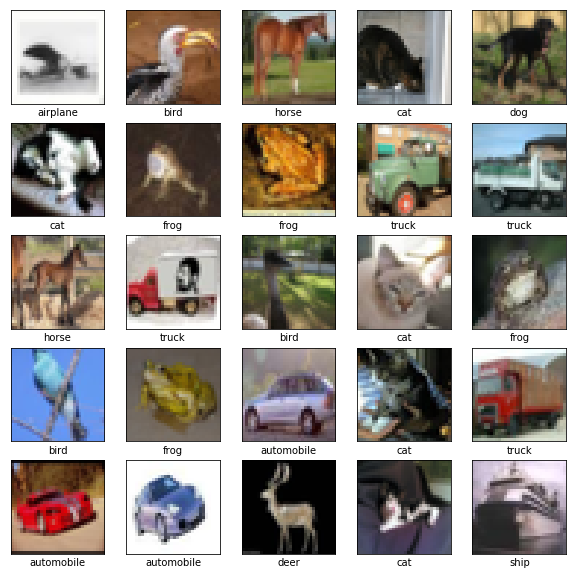

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

In [27]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         221312    
__________

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [28]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         221312    
__________

### Aside: Random initialization schemes

You might have wondered what values we are using for the initial values of the weights and biases in our model. The short answer is that we typically use random initialization. In this case, we have just been using the default keras initializers for each layer, which are usually sufficient.

The longer answer is that just using completely random numbers does not always work best in practice and that there are a number of common initialization schemes (which are available in most deep learning frameworks such as TensorFlow and Keras).

Lets consider a few examples:

 * When using the ReLU activation it is common to initialize the biases with small positive numbers because this encourages the ReLU activations to start off in the _on_ state, which helps to counteract the _dying ReLU problem_.

 * The deeper neural networks become the more likely it is that gradients will either shrink to the point that they vanish, or grow to the point that they overflow (the _vanishing_ and _exploding_ gradients problems). To help combat this we can initialize our weights to have a (model-specific) appropriate scale. One method for doing this is called [_Xavier_ or _Glorot_](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization.

 * The _Xavier_ initialization scheme was designed with the _traditional_ activations Sigmoid and TanH in mind, and does not work as well for ReLU activations. An alternative is [_He_](https://arxiv.org/pdf/1502.01852.pdf) initialization which is a modification of _Xavier_ initialization for ReLU activations.

 [This blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) goes into more detail on _He_ and _Xavier_ initialization. [The Keras documentation](https://keras.io/initializers/) lists a number of common schemes. 

### Visualizing the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

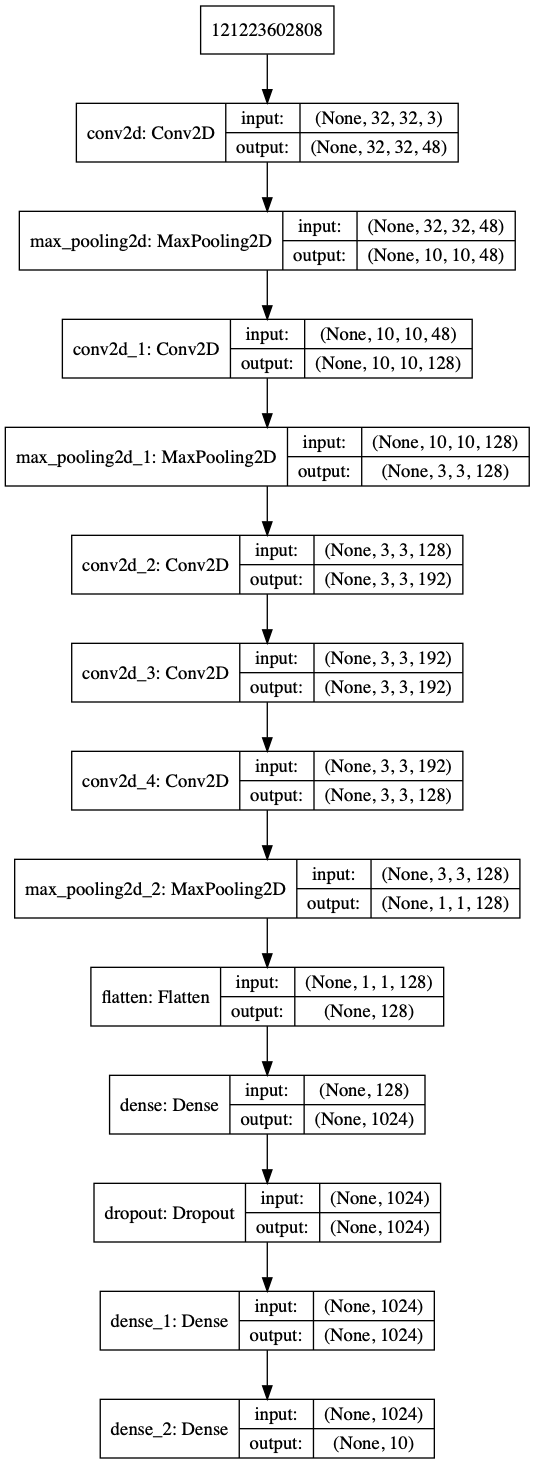

In [10]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


### Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [29]:
batch_size = 128
num_epochs = 3  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 93s 2ms/sample - loss: 1.7360 - acc: 0.3767 - val_loss: 1.3768 - val_acc: 0.5073
Epoch 2/3
40000/40000 [==============================] - 91s 2ms/sample - loss: 1.2970 - acc: 0.5321 - val_loss: 1.2375 - val_acc: 0.5607
Epoch 3/3
40000/40000 [==============================] - 89s 2ms/sample - loss: 1.1539 - acc: 0.5920 - val_loss: 1.1101 - val_acc: 0.6096
Training complete


### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [30]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 6s 610us/sample - loss: 1.1183 - acc: 0.6030
Final TEST performance
loss: 1.1183240920066833
acc: 0.6029999852180481


Using 10 epochs: Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [25]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

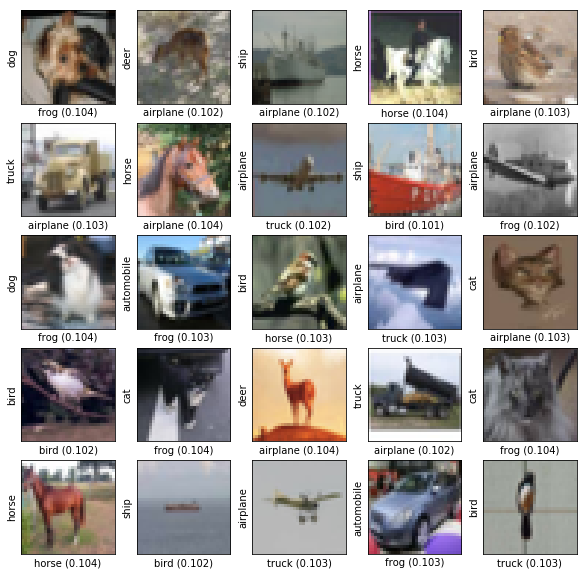

In [26]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Aside: Uncertainty in deep learning

Deep neural networks are not considered to be very good at estimating the uncertainty in their predictions. However, knowing your model's uncertainty can be very important for many applications. For example, consider a deep learning tool for diagnosing diseases, in this case a false negative could have massive impacts on a person's life! We would really like to know how confident our model is in its prediction. This is a budding field of research, for example see [this blog](https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html) for a nice introduction.

### Aside: CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.




## Your Tasks

1. Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2.  Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.

5. Why do modern architectures use less max-pooling?
6. What does a 1x1 convolution do?
7. What is a residual connection?

##Additional Resources for your own time

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)



## 1. Experimenting with the architecture

Below I will experiment with the architecture of the proposed ConvNet. The ideal would be to compare the output from a GoogLeNet, ZFNet, VGGNet or RestNet to the model built above. This way we can see how our model fares against some of the best ConvNets on the market. However, these ConvNets are very 'deep' and require significant computing power. Additionally, the process of tuning their parameters to produce reasonable results is not a trivial exercise. Comparing such complex models to our model is therefore deemed to be out of scope for this task.

For the below section I will adjust the following:
1. Number of convolutional layers
2. Number of hidden (fully-connected) layers
3. See what happens when we remove the dropout regularization technique
4. Whether we use max-pooling or not 

Finally, I will reduce the number of epochs slightly in order to speed up runtimes. One can always increase the number of epochs to train the model on once a final, most-suitable model has been identified.

In [34]:
# The below two code cells were used to experiment with the model architecture. The results are reported just below these two cells.

# Define the convolutional part of the model architecture using Keras Layers.
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

# Adding the fully-connected layers
model_2.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model_2.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model_2.add(tf.keras.layers.Dropout(rate=0.5))
model_2.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model_2.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# Training and validating the model
batch_size = 128
num_epochs = 3  # The number of epochs (full passes through the data) to train for

# Adding a loss function, optimiser and metrics to track during training
model_2.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fitting the compiled model to some training data
model_2.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 94s 2ms/sample - loss: 1.7216 - acc: 0.3753 - val_loss: 1.3388 - val_acc: 0.5171
Epoch 2/3
40000/40000 [==============================] - 91s 2ms/sample - loss: 1.2491 - acc: 0.5549 - val_loss: 1.2087 - val_acc: 0.5753
Epoch 3/3
40000/40000 [==============================] - 94s 2ms/sample - loss: 1.0751 - acc: 0.6234 - val_loss: 1.0387 - val_acc: 0.6417
Training complete


In [35]:
# Testing the performance of the above model

metric_values = model_2.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model_2.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 6s 638us/sample - loss: 1.0443 - acc: 0.6404
Final TEST performance
loss: 1.0442657905578614
acc: 0.6403999924659729


## OUTCOME OF THE ABOVE EXPERIMENTATION:

As a baseline, we use the results of the initial model to judge the results of the adapted models. However, we have also used 3 epochs on the initial/baseline model to ensure that the model comparisons are consistent. The initial model (with 5 convolutional layers and 2 dense layers) had the following results:

 - Roughly 62% accuracy on the training set.
 - Roughly 64% accuracy on the test set.

1. The first adapted model I ran had two convolutional layers (both with max-pooling) and a single fully-connected layer. This format is the same as the LeNet-5 (1998) ConvNet built by by LeCun et al in 1998. 

Observation: 

 - Roughly 10% accuracy on the training set.
 - Roughly 10% accuracy on the test set.
 
From the above results it seems as though this model does not do well in identifying the given images. With an accuracy of only (roughly) 10% on both the training and test data we would not be comfortable in using this model. At this stage it seems that REMOVING 3 convolutional layers and a fully connected layer is not a good idea. This is surprising to me though. Seeing that this model is of similar shape as the LeNet model of 1998, I would have expected better results than the 10% accuracy displayed above. We have to recognize that a model of this shape might yield better results that those shown above if different parameters were used or if the model were run on a larger number of epochs.

2. The second model I ran saw an increase in the number of layers in the model compared to the initial model we built. The updated model had 7 convolutional layers as well as 5 fully-connected layers (with max-pooling and the dropout regularization technique).

Observation:

 - Roughly 43% accuracy on the training set.
 - Roughly 46% accuracy on the test set.
 
From the above results we can see that an increase in the number of layers has improved the previous (2 convolutional layers and a single fully connected layer) model's performance by a factor of more than 4. 
The greater the number of filters we have, the more image features get extracted and the better our network becomes at recognizing patterns in unseen images. Thus, the more convolutions we have (and hence the more convolution layers we have) the more filters we apply to the input data, which in turn leads to better recognition of unseen images if we use the above argument. So we could have expected the above improvements in the results, at least to some extent, that result from an increase in the numbeer of layers we use in the model. Again, increasing the number of epochs and tuning the hyperparameters differently could increase the accuracy even further without needing to make fundamental changes to the model structure.

However, this model still performs worse than the baseline model. 

3. The third model was similar to the initial model set out in this task (5 convolutional layers and 3 dense layers), with the exception that no dropout regularization technique was used.

Observation:

 - Roughly 62% accuracy on the training set.
 - Roughly 62% accuracy on the test set.
 
First of all, let's define the term 'Dropout': Dropout is a regularization technique where the model is incentivised to remain as simple as possible. This is done in an attempt to prevent overfitting and penalise complexity in the NN. With 'dropout' activated, the input to a particular neuron is randomised, i.e. not all neurons in the previous layer pass their values to that particular neuron. This means that a particular neuron cannot rely too heavily on any one of the neurons in the previous layer, since it might not receive input from that neuron going forward. 

From the results above we see that this model, where the dropout has been removed, performs more or less the same as the baseline model on both the training set and the test set. We would expect the model with no dropout to outperform the model with a dropout on the training set. This is because the model with the dropout discards some of the training input data, whereas the model with no dropout does not. 

It's interesting to note that the model with no dropout performs similarly to the baseline model on the test set. Seeing that dropout regularization was designed to ensure that the model does not overfit on the training data, we would not be surprised to see the model with a dropout to perform better on a test set than a model with no dropout. We could still observe such results on a different dataset or when using a different number of epochs.

4. The final model tested here looked at a model with 5 convolutional layers and 2 dense layers (similar to the initial model), but with no max-pooling in between ther convolutional layers.

Observation:

The runtime of the model was very long. And my laptop almost exploded:) So it seems to me that the max-pooling layers are required in between the convolutional layers, at least for common, general-purpose laptops. In hindsight this makes sense -> the max-pool layer summarises the data and reduces the dimensionality, thereby leading to quicker runtimes. The hope here is that the pooling method chosen does in fact retain the most important information received from the previous layer.

## 2. Implementing BATCH NORMALISATION to improve the model's generalisation

In [40]:
'''
First, what is batch normalization? 

Larger data points in non-normalized datasets can cause imbalances in a Neural Network (NN), which cascades through the rest of the NN.
This in turn can cause imbalanced gradients, which contributes to the 'Exploding gradient problem'. So what we can do is scale our input data points and put them
on the same scale. This addresses the Exploding gradient problem directly, as well ass improves NN training speeds. This explains why we scale our input data.

However, the problem with NN's also arises where a weight in the NN becomes drastically larger/smaller than the others, which means that the output that this neuron passes
to the next layer becomes very large/small. This effect also cascades through the rest of the NN and causes undesired imbalances. This is where batch noralization (BN)
comes in. BN is applied to a layer and normalizes the output from that layer's activation function. This process is also optimised during the training process, i.e.
the parameters required to normalize the output from a layer are refined as the model learns. 

So if we apply BN, not only do we have normalized data fed into the model, but we also end up with normalized data WITHIN the model. This can reduce the imbalances
caused by very large/small weights in the model and improves the training times on the model.

Lastly, BN is run on a 'per batch basis' - hence the name 'Batch Normalization'.
'''

# Below is the code for the new model where I implemented batch normalization. The results of this effort are set out at below this cell and the next.
from keras.layers import BatchNormalization

# insert the following code between the dense layers in your model
# tf.keras.layers.BatchNormalization(axis = 1)

# Define the convolutional part of the model architecture using Keras Layers.
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

# Adding the fully-connected layers
# Also adding the batch normalization code
model_3.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model_3.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model_3.add(tf.keras.layers.Dropout(rate=0.5))
model_3.add(tf.keras.layers.BatchNormalization(axis = 1)) # Batch normalization
model_3.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model_3.add(tf.keras.layers.BatchNormalization(axis = 1)) # Batch normalization
model_3.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

# Training and validating the model
batch_size = 128
num_epochs = 3  # The number of epochs (full passes through the data) to train for

# Adding a loss function, optimiser and metrics to track during training
model_3.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fitting the compiled model to some training data
model_3.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 91s 2ms/sample - loss: 2.1897 - acc: 0.2352 - val_loss: 4.0276 - val_acc: 0.1045
Epoch 2/3
40000/40000 [==============================] - 93s 2ms/sample - loss: 1.4444 - acc: 0.4714 - val_loss: 1.4606 - val_acc: 0.4746
Epoch 3/3
40000/40000 [==============================] - 91s 2ms/sample - loss: 1.2001 - acc: 0.5669 - val_loss: 1.3660 - val_acc: 0.5407
Training complete


In [41]:
# Testing the performance of the above model

metric_values = model_3.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model_3.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 6s 634us/sample - loss: 1.3689 - acc: 0.5356
Final TEST performance
loss: 1.3689035545349122
acc: 0.5356000065803528


From the above results we observe that the accuracy on the training set and the test set are roughly 57% and 54%, respectively. This is slightly lower than the baseline model's performance, i.e. where no batch normalization is applied. These results are not enough to formally conclude that using batch normalization weakens our model performance. I would suggest we use a larger number of epochs and play around with where the batch normalization occurs within the NN. This could produce different results. The main goal for me here was to find out what batch normalisation is, what it's supposed to do and where/how it can be implemented. 

## 3. Why do modern architectures use less max pooling?

The most obvious reason for this is that pooling discards a lot of data that could otherwise be used. Data scientists should be careful to simply discard data. 

State-of-the-art performance can be achieved without pooling. Using pooling layers is not always necessary for the model to perform optimally. Alternative methods have been proposed and are reported to perform as well as (or even better than) CNNs with pooling layers. One of the proposed alternatives is to remove the pooling layer(s) and increase the stride of the convolutional layers. Another alternative is that we could replace the pooling layers with convolutional layers with a stride larger than 1. These methods seems to be most efficient if the network is large enough for the dataset it is being trained on. These proposed methods also reduce dimensionality, which is one of the goals of pooling layers. Another proposed method is to use 'data augmentation', where images are broken down into smaller pieces (i.e. more pixels) and scaled, rotated and color augmented. This method drastically increases the number of parameters the model uses. Such models' performance are also comparable to those that make use of pooling while negating the need for pooling layers. 

Removing pooling layers from a CNN will simplify the model, which in turn could make it more explicable and easier to interpret. 

We have to keep in mind that adding pooling layers to a CNN does in many cases improve the model's performance. We should therefore be careful to simply omit pooling layers.

A final and perhaps peripheral reason that modern architectures will make less use of pooling is that computing power improves every year, thus reducing (however slight) the need for dimensionality reduction.

## 4. What is a 1x1 Convolution?

General:

 - A 1×1 convolution is used as a dimension reduction module to reduce the size of the computation. By reducing the computation bottleneck, depth and width can be increased. It is also known to reduce overfitting.

What is it?
 - It is a simple 1×1 filter that provides a way to usefully summarize the input feature maps. The use of multiple 1×1 filters, in turn, allows the tuning of the number of summaries of the input feature maps to create, effectively allowing the depth of the feature maps to be increased or decreased as needed.

 - A convolutional layer with a 1×1 filter can, therefore, be used at any point in a convolutional neural network to control the number of feature maps. It is often referred to as a projection operation or projection layer, or even a feature map or channel pooling layer.

Why is it useful?
 - It is a way to make our ConvNets deeper without changing the ConvNet's structure
 - It's 'cheap' way to do the above in terms of computational expenditure
 - Reduces the need for padding


## 5. What is a residual connection?

Some background:

 - A common problem in deep learning is the problem of 'degradation'. This is where after a certain point in training a NN, the more layers are added the higher the error rates become. This will often be misconstrued as overfitting. However, degradation refers to an increase in TRAINING errors, not is the TEST errors.
 - In the degradation problem, shallower networks perform better than the deeper networks that have more layers added to them. The question then arises... Why not skip these extra layers and at least match the accuracy of the shallower networks?
 
Enter 'residual connections':

 - A residual connection is a connection in a NN where the connection between one layer and another 'skips' one or more layers.
 - If we use residual connections we'll see that for different training data points, different parts of the network will be trained at different rates based on how the error flows backwards in the network.
 - By adding residual connections to our network, we are allowing the network to skip training for the layers that are not useful and do not add value in overall accuracy. Residual connections are said to make our neural networks more dynamic, so that it may optimally tune the number of layers during training. This in turn reduces the risk of degradation.